In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud


### Reading .csv file

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True, usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

10000000

### Data Processing

In [7]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy() ## Filtering experienced user from inexperienced user

In [8]:
n_ratings

user_id
20807    17546
11100    14429
22022    13696
16869     8943
10255     8403
         ...  
20973        1
17895        1
16803        1
3682         1
16019        1
Name: count, Length: 30006, dtype: int64

In [9]:
len(rating_df)

6529917

In [10]:
min_rating = min(rating_df["rating"])

In [11]:
min_rating

0

In [12]:
max_rating = max(rating_df["rating"])

In [13]:
max_rating

10

In [14]:
avg_rating = np.mean(rating_df["rating"])

In [15]:
avg_rating

np.float64(4.073779191986667)

In [16]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [17]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

In [18]:
ratings =   [min_rating,
    max_rating,
    avg_rating]
ratings

[0.0, 1.0, np.float64(0.4073779191986666)]

In [19]:
rating_df.duplicated().sum()

np.int64(0)

In [20]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [21]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [22]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [23]:
n_users = len(user2user_encoded)

In [24]:
n_users

8348

In [25]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [26]:
n_anime = len(anime2anime_encoded)
n_anime

17554

In [27]:
# Introducing randomness in the dataframe
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)


In [28]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,26757,15225,0.8,6863,1176
1,12849,33244,0.9,3257,4833
2,8982,40465,0.0,2237,11965
3,20064,47,0.5,5133,833
4,22729,3791,0.8,5787,4794


In [29]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y, test_size=1000, random_state=43)

In [31]:
len(X_train)

6528917

In [32]:
len(X_test)

1000

In [33]:
type(X_train)

numpy.ndarray

In [34]:
X_train_array = [X_train[: , 0], X_train[:,1]]
X_test_array = [X_test[: , 0], X_test[:,1]]

In [35]:
type(X_test_array)

list

In [36]:
type(X_test_array[0])

numpy.ndarray

### Model Architecture

In [37]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users,output_dim=embedding_size)(user)
    
    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" ,normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)

    x = Activation("sigmoid")(x) 

    model = Model(inputs=[user,anime], outputs=x)

    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [38]:
model = RecommenderNet()

In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,068,544 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,912 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,315,462 (12.65 MB)

 Trainable params: 3,315,460 (12.65 MB)

 Non-trainable params: 2 (8.00 B)

In [40]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [41]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)


In [42]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [43]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 0.7729 - mae: 0.3782 - mse: 0.1891 - val_loss: 0.7649 - val_mae: 0.3902 - val_mse: 0.1913 - learning_rate: 1.0000e-05
Epoch 2/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.7678 - mae: 0.3765 - mse: 0.1871 - val_loss: 0.7865 - val_mae: 0.3946 - val_mse: 0.1989 - learning_rate: 1.8000e-05
Epoch 3/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.7593 - mae: 0.3737 - mse: 0.1836 - val_loss: 0.7797 - val_mae: 0.3930 - val_mse: 0.1963 - learning_rate: 2.6000e-05
Epoch 4/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.7470 - mae: 0.3693 - mse: 0.1785 - val_loss: 0.7696 - val_mae: 0.3901 - val_mse: 0.1922 - learning_rate: 3.4000e-05


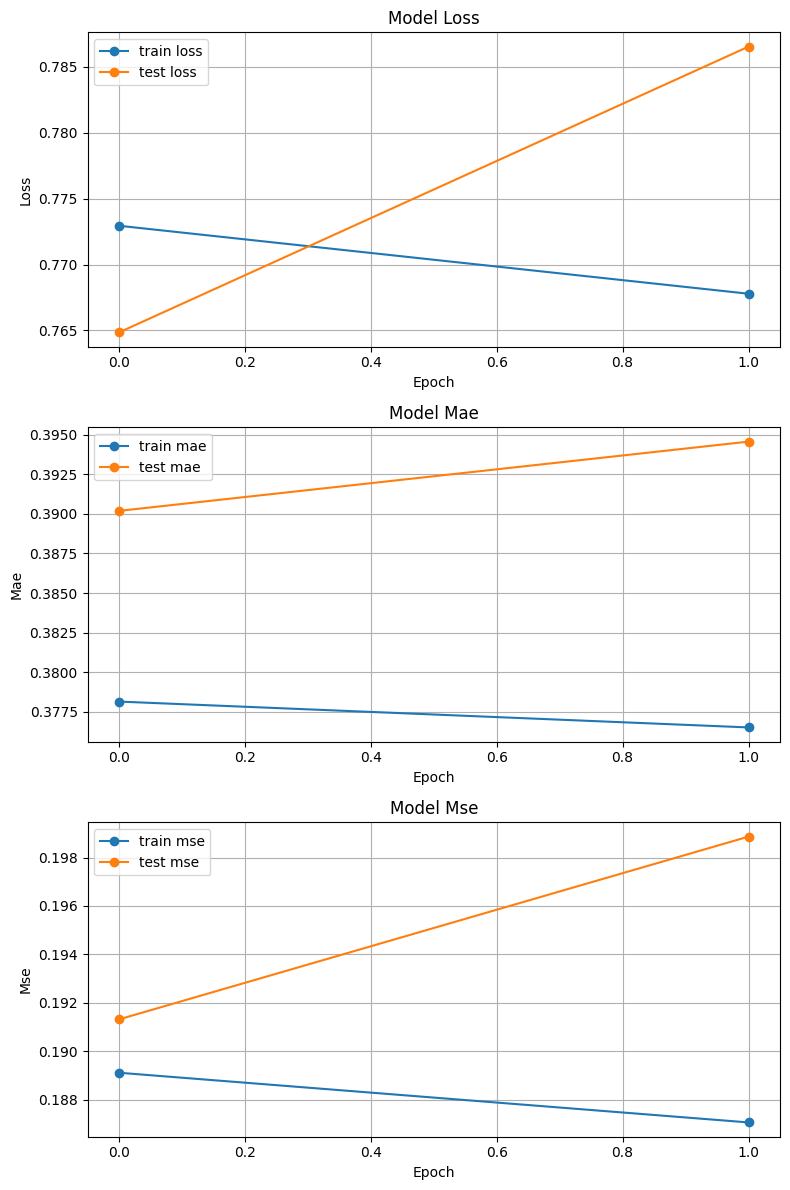

In [44]:
metrics = ["loss","mae","mse"]

#Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) *4 ))

for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:2],marker="o",label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [45]:
def extract_weights(name,model):
    weight_layer= model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [46]:
anime_weights = extract_weights("anime_embedding",model)

In [47]:
user_weights = extract_weights("user_embedding",model)

## Reading anime.csv

In [48]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [49]:
df = df.replace("Unknown",np.nan)

In [50]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    
    except:
        print("Error")
    return name

In [51]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]

In [52]:
df["eng_version"] = df.anime_id.apply( lambda x:getAnimeName(x))

In [53]:
df["eng_version"].isna().value_counts()

eng_version
False    17562
Name: count, dtype: int64

In [54]:
getAnimeName(6702)

'Fairy Tail'

In [55]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [56]:
df.sort_values(by='Score', inplace=True, ascending=False,kind="quicksort", na_position="last")

In [57]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood


In [58]:
pd.set_option('display.max_rows', None)

In [59]:
df["Studios"].value_counts()

Studios
Toei Animation                                                                      755
Sunrise                                                                             479
J.C.Staff                                                                           358
Madhouse                                                                            324
TMS Entertainment                                                                   277
Production I.G                                                                      266
Studio Deen                                                                         263
Studio Pierrot                                                                      249
OLM                                                                                 212
Nippon Animation                                                                    208
A-1 Pictures                                                                        193
DLE                     

In [60]:
df["Source"].value_counts()

Source
Original         5215
Manga            3825
Visual novel      993
Game              880
Light novel       768
Other             597
Novel             510
Music             317
4-koma manga      288
Web manga         252
Picture book      147
Book              112
Card game          64
Digital manga      15
Radio              12
Name: count, dtype: int64

In [61]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [62]:
df = df[["anime_id","eng_version",'Score','Genres','Episodes','Type','Premiered','Studios','Source']]

In [63]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,Bones,Manga
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,MAPPA,Manga
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,White Fox,Visual novel
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,Wit Studio,Manga
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,Bandai Namco Pictures,Manga


In [64]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [65]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,MAPPA,Manga


In [66]:
getAnimeFrame("Gintama Season 4",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,Bandai Namco Pictures,Manga


## Reading anime_with_synopsis.csv

In [67]:

syn_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",low_memory=True)

In [68]:
syn_df.head(10)

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college..."
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent..."


In [69]:
syn_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'sypnopsis'], dtype='object')

In [70]:
syn_df.drop(columns=['Score'], inplace=True)

In [71]:
syn_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [72]:
# Merge syn_df with the 'anime_id' and 'eng_version' columns from df
syn_df = syn_df.merge(df[['anime_id', 'eng_version']], left_on='MAL_ID', right_on='anime_id', how='left')

# If you want, you can drop the redundant 'anime_id' column
syn_df.drop(columns=['anime_id'], inplace=True)

In [73]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return syn_df[syn_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return syn_df[syn_df.eng_version == anime].sypnopsis.values[0]

In [74]:
syn_df.head(10)

,MAL_ID,Name,Genres,sypnopsis,eng_version
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",Cowboy Bebop:The Movie
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",Trigun
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,Witch Hunter Robin
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,Beet the Vandel Buster
5,15,Eyeshield 21,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...,Eyeshield 21
6,16,Hachimitsu to Clover,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college...",Honey and Clover
7,17,Hungry Heart: Wild Striker,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...,Hungry Heart: Wild Striker
8,18,Initial D Fourth Stage,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...,Initial D Fourth Stage
9,19,Monster,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent...",Monster


In [75]:
getSynopsis(19,df)

"Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—losing his social standing being one of them. However, with the mysterious death of the director and two other doctors, Dr. Tenma's position is restored. Wit

In [76]:
getSynopsis("Gintama Season 4",df)

"Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an alternate-reality Edo, where swords are prohibited and alien overlords have conquered Japan, they try to thrive on doing whatever work they can get their hands on. However, Shinpachi and Kagura still haven't been paid... Does Gin-chan really spend all that cash playing pachinko? Meanwhile, when Gintoki drunkenly staggers home one night, an alien spaceship crashes nearby. A fatally injured crew member emerges from the ship and gives Gintoki a strange, clock-shaped device, warning him that it is incredibly powerful and must be safeguarded. Mistaking it for his alarm clock, Gintoki proceeds to smash the device the next morning and suddenly discovers that the world outside his apartment has come to a standstill. With Kagura and Shinpachi at his side, he sets off to get the device fixed; though, as usual, nothing is ever that simple for the Yorozuya team. Filled with tongue-in-cheek

In [77]:
syn_df.isnull().sum()

MAL_ID         0
Name           0
Genres         0
sypnopsis      8
eng_version    0
dtype: int64

In [78]:
syn_df[syn_df.isnull().any(axis=1)]

,MAL_ID,Name,Genres,sypnopsis,eng_version
11451,34755,Kuma no Gakkou: Patissier Jackie to Ohisama no...,"Comedy, Kids",NaN,Kuma no Gakkou: Patissier Jackie to Ohisama no...
11469,34794,Yukai na Animal Bus,"Comedy, Kids",NaN,Funny Animal Bus
13686,38475,Yuru Camp△ Movie,"Comedy, Slice of Life",NaN,Yuru Camp△ Movie
15025,40714,Youkai Watch Jam: Youkai Gakuen Y - N to no So...,"Comedy, Demons, Kids, Supernatural, School",NaN,Youkai Watch Jam: Youkai Gakuen Y - N to no So...
15747,42717,Kaeru no Pickles: Kimochi no Iro,"Slice of Life, Kids",NaN,Kaeru no Pickles: Kimochi no Iro
16056,44848,Iii Icecrin,Kids,NaN,Iii Icecrin
16110,45731,Argonavis from BanG Dream! Movie,Music,NaN,Argonavis from BanG Dream! Movie
16120,46095,Vivy: Fluorite Eye's Song,Sci-Fi,NaN,Vivy: Fluorite Eye's Song


In [79]:
syn_df[syn_df['Genres'] == 'Hentai']

,MAL_ID,Name,Genres,sypnopsis,eng_version


In [80]:
miss_df = df[~df['anime_id'].isin(syn_df['MAL_ID'])]

In [81]:
miss_df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
15573,39392,Master Piece The Animation,7.76,Hentai,2,OVA,NaN,NaN,Manga
10065,29575,Mankitsu Happening,7.72,Hentai,4,OVA,NaN,Collaboration Works,Visual novel
16586,41261,Ane wa Yanmama Junyuu-chuu,7.64,Hentai,2,OVA,NaN,T-Rex,Manga
9320,25345,Rance 01: Hikari wo Motomete The Animation,7.64,"Fantasy, Hentai, Magic",4,OVA,NaN,Seven,Visual novel
16790,41848,Isekai Harem Monogatari,7.59,"Fantasy, Harem, Hentai",NaN,OVA,NaN,NaN,Manga


In [82]:
df.drop(miss_df.index, inplace=True)

In [83]:
df.shape

(16214, 9)

In [84]:
df[~df['anime_id'].isin(syn_df['MAL_ID'])]

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source


## Content/Item - Based Recommendation

In [85]:
pd.set_option("max_colwidth",None)

In [86]:
getAnimeFrame(28977,df).anime_id.values[0] ## we get index of the anime

np.int64(28977)

In [87]:
anime2anime_encoded.get(28977) ## we get the original index 

1816

In [88]:
np.dot(anime_weights,anime_weights[1816]) ## we are getting vectors from it

array([ 0.11875384, -0.05429814, -0.03304778, ...,  0.09485052,
        0.09756088, -0.12797505], dtype=float32)

| Part                                 | What It Does                                      |
|--------------------------------------|---------------------------------------------------|
| `anime_weights[1816]`                | Vector for anime #1816                            |
| `np.dot(anime_weights, anime_weights[1816])` | Similarity between all anime and #1816   |
| `np.argsort(...)`                    | Indices to sort similarities in ascending order   |


In [89]:
np.argsort(np.dot(anime_weights,anime_weights[1816])) 

array([  837, 15532,  5368, ..., 11929,  9559,  1816])

In [273]:
def find_similiar_animes(name,anime_weights,anime2anime_encoded,
                         anime2anime_decoded,df,n=10,return_dist=False,neg=False):
    
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]
        

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            

            anime_frame = getAnimeFrame(decoded_id,df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                
            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
    
    except Exception as e:
        print("Error occured",e)
    

In [278]:
def find_similiar_animes_1(name, anime_weights, anime2anime_encoded,
                         anime2anime_decoded, df, n=10, return_dist=False, neg=False):
    
    try:
        # Attempt to get the anime's row from the DataFrame
        anime_frame = getAnimeFrame(name, df)

        if anime_frame.empty:
            print(f"No anime found with name: '{name}'")
            return None

        index = anime_frame.anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        if encoded_index is None:
            print(f"Anime ID '{index}' not found in encoded dictionary")
            return None

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1  # +1 because we remove the anime itself later

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]

        if return_dist:
            return dists, closest

        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            if decoded_id is None:
                continue

            similar_frame = getAnimeFrame(decoded_id, df)
            if similar_frame.empty:
                continue

            anime_name = similar_frame.eng_version.values[0]
            genre = similar_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
            })

        if not SimilarityArr:
            print(f"No similar animes found for '{name}'")
            return None

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)

        # Remove the original anime from results
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)

    except Exception as e:
        print("Error occurred:", e)
        return None


In [279]:
find_similiar_animes_1("Cowboy Bebop",anime_weights,anime2anime_encoded,anime2anime_decoded,
                     df)

,name,similarity,genre
1,Super Lovers 2,0.343005,"Slice of Life, Comedy, Drama, Romance, Shounen Ai"
2,Itazura Tenshi Chippo-chan,0.340687,"Comedy, Kids"
3,Start Signal,0.331461,Music
4,Kurokami: Tora to Tsubasa,0.325844,"Action, Super Power, Martial Arts, Seinen"
5,Maken-Ki! Two,0.315462,"Action, Harem, Super Power, Ecchi, Martial Arts, School"
6,crack,0.308837,Music
7,Ginga Kikoutai Majestic Prince Movie: Kakusei no Idenshi,0.302167,"Action, Sci-Fi, Space, Mecha, School, Seinen"
8,Nurse Witch Komugi-chan R,0.288378,"Comedy, Magic, Parody"


### User Based Recommendation/ Collabrative Filtering

In [111]:
user2user_decoded.get(0)

2

In [117]:
enc_user = user2user_encoded.get(11880)
enc_user

3009

In [123]:
dic = np.dot(user_weights,user_weights[enc_user])

In [125]:
sorted_dic = np.argsort(dic)
sorted_dic

array([5092, 1122, 1034, ..., 2514, 5158, 3009])

In [128]:
n=10
n=n+1
nega=False

if nega:
    close = sorted_dic[:n]
else:
    close = sorted_dic[-n:][::-1]

close

array([3009, 5158, 2514, 2471,  878,  633, 7842, 5153,  202, 7215, 7638])

In [198]:
def find_similiar_user(item_input, user_weights,user2user_encoded,
                       user2user_decoded,n=10,return_dist=False,neg=False):
    try:
        index = int(item_input)
        encoded_index = user2user_encoded.get(index)
        weights = user_weights

        if encoded_index is not None:

            dists = np.dot(weights,weights[encoded_index])
            sorted_dists = np.argsort(dists)

            n=n+1
            
            if neg:
                closest = sorted_dists[:n]
            else:
                closest = sorted_dists[-n:][::-1]
            

            if return_dist:
                return dists,closest
            
            SimiliarityArr = []

            for close in closest:
                similarity = dists[close]

            
                decoded_id = user2user_decoded.get(close)
                SimiliarityArr.append({
                    "similiar_users" : decoded_id,
                    "similarity" : similarity,
                    
                })
                
                sim_users = pd.DataFrame(SimiliarityArr).sort_values(by="similarity",ascending=False) 
                sim_users = sim_users[sim_users.similiar_users != item_input]
            return sim_users
        else:
            print(f"Cannot find similiar users for {item_input}! ")
    except Exception as e:
        print("Error occured",e)
         

In [199]:
find_similiar_user(11880,user_weights,user2user_encoded,user2user_decoded)

,similiar_users,similarity
1,20186,0.376964
2,10086,0.351945
3,9904,0.319719
4,3541,0.313080
5,2523,0.278185
6,30610,0.275818
7,20155,0.275565
8,776,0.274302
9,28190,0.271290
10,29836,0.268470


In [139]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [141]:
from collections import defaultdict

In [147]:
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list =[]
    for genres in frame['Genres']:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    
    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [148]:
cb = getAnimeFrame(1,df)

In [149]:
cb

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,Sunrise,Original


In [150]:
getFavGenre(cb)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

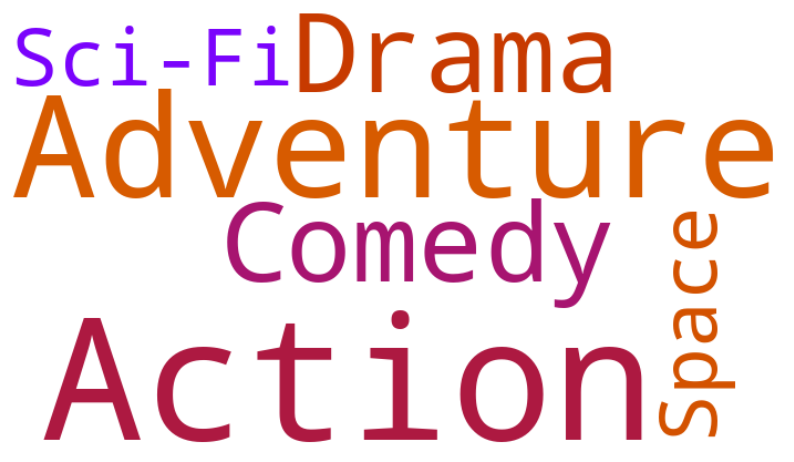

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [151]:
getFavGenre(cb , plot=True)

In [152]:
rating_df.head(3)

,user_id,anime_id,rating,user,anime
0,26757,15225,0.8,6863,1176
1,12849,33244,0.9,3257,4833
2,8982,40465,0.0,2237,11965


In [170]:
r = rating_df[rating_df.user_id == 1]
r.shape

(0, 5)

In [171]:
if not r.rating.empty:
    u = np.percentile(r.rating, 75)
else:
    u = np.nan

In [167]:
u = np.percentile(r.rating , 75)
if u is 0:
    True

<>:2: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?


IndexError: index -1 is out of bounds for axis 0 with size 0

In [172]:
nr = r[r.rating >= u]
nr.shape

(0, 5)

In [210]:
def get_user_preferences(user_id, rating_df,df, verbose=0, plot=False ):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    if not animes_watched_by_user.rating.empty:
        user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)
    else:
        user_rating_percentile = np.nan


    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating",ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if not anime_df_rows.empty :
      if plot:
          getFavGenre(anime_df_rows, plot=True)
    

    return anime_df_rows



In [213]:
get_user_preferences(0,rating_df,df)

,eng_version,Genres


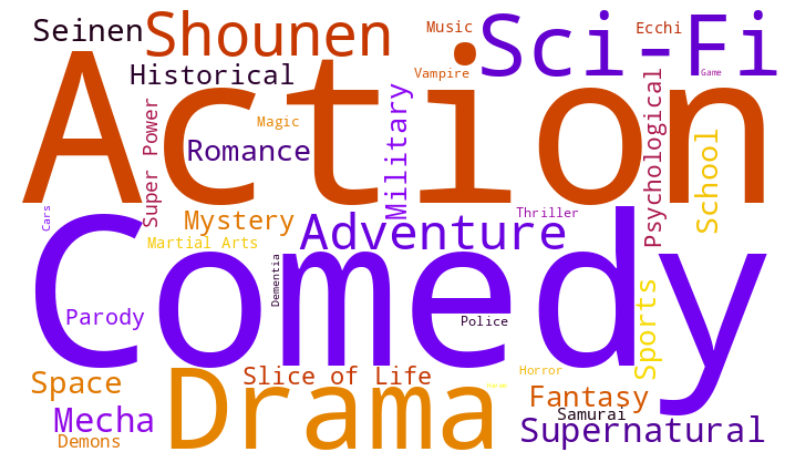

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7249,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
833,Gintama,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7577,Monogatari Series:Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"


In [211]:
get_user_preferences(11880,rating_df,df,plot=True)

In [250]:
def get_user_recommendations(similar_users,user_pref,df,rating_df,syn_df,n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similiar_users.values:
        pref_list = get_user_preferences(user_id,rating_df,df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i,anime_name in enumerate(sorted_list.index):
            n_users_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name,df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                

                recommended_animes.append({
                    "n" : n_users_pref,
                    "anime_name" : anime_name,
                    "Genres": genre,
                    
                })
    return pd.DataFrame(recommended_animes).head(n)
               

    

In [206]:
similar_users = find_similiar_user(11880,user_weights,user2user_encoded,user2user_decoded)

In [214]:
user_pref = get_user_preferences(11880,rating_df,df)

In [ ]:
rating_df

In [254]:
get_user_recommendations(similar_users,user_pref,df,rating_df,syn_df)

,n,anime_name,Genres
0,8,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen"
1,8,Princess Mononoke,"Action, Adventure, Fantasy"
2,7,Angel Beats!,"Action, Comedy, Drama, School, Supernatural"
3,7,When They Cry,"Mystery, Dementia, Horror, Psychological, Supernatural, Thriller"
4,7,Shakugan no Shana:Season I,"Action, Drama, Fantasy, Romance, School, Supernatural"
5,7,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Romance"
6,7,Spirited Away,"Adventure, Supernatural, Drama"
7,7,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen"
8,7,anohana:The Flower We Saw That Day,"Slice of Life, Supernatural, Drama"
9,7,When They Cry:Kai,"Mystery, Psychological, Supernatural, Thriller"


## Hybrid Recommender System

In [298]:
def hybrid_recommendation(user_id,user_weight=0.5, content_weights=0.5):
    
    ## user recommendation
    similar_users = find_similiar_user(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id,rating_df,df)
    user_recommended_animes = get_user_recommendations(similar_users,user_pref,df,rating_df,syn_df)

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    ## content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        
        similar_animes = find_similiar_animes_1(str(anime),anime_weights,anime2anime_encoded,anime2anime_decoded,df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
        
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weights
    
    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] ,reverse=True )

    return [anime for anime , score in sorted_animes]


In [265]:
find_similiar_animes('No Game, No Life',anime_weights,anime2anime_encoded,anime2anime_decoded,df,n=2)

,name,similarity,genre
1,Saban's Adventures of the Little Mermaid,0.324570,"Drama, Fantasy, Kids, Romance"
2,Hello Kitty in Santa's Missing Hat,0.323443,"Kids, Fantasy"


In [299]:
hybrid_recommendation(11880)

['Death Note', 'Princess Mononoke', 'Angel Beats!', 'When They Cry', 'Shakugan no Shana:Season I', 'Clannad ~After Story~', 'Spirited Away', 'Nisekoi:False Love', 'anohana:The Flower We Saw That Day', 'When They Cry:Kai']


['Death Note',
 'Princess Mononoke',
 'Angel Beats!',
 'When They Cry',
 'Shakugan no Shana:Season I',
 'Clannad ~After Story~',
 'Spirited Away',
 'Nisekoi:False Love',
 'anohana:The Flower We Saw That Day',
 'When They Cry:Kai',
 'Blue Legend Shoot!',
 'Chinpui',
 "Doraemon the Movie:Nobita's Dinosaur",
 'Planetarian: Snow Globe',
 'Patema Inverted',
 'Locke the Superman:Mirror Ring',
 'Eagle Riders',
 'My Hero Academia Season 2:Hero Notebook',
 'Broadcast by Bibby',
 'Tatakau Mono-tachi e Ai wo Komete',
 'Love, Chunibyo & Other Delusions!:Heart Throb Lite Shorts',
 'Massugu ni Ikou. 2nd Season',
 'Dr. Typhoon',
 'Kokoro no Catchball',
 'Hajime Ningen Gyatoruz',
 'Return of Pero',
 'Ginga Eiyuu Densetsu: Die Neue These - Seiran 2',
 'Non Non Biyori: Okinawa e Ikukoto ni Natta',
 'I Am Nezha',
 'God Eater',
 'The Cosmopolitan Prayers',
 'Shibawanko no Wa no Kokoro',
 'Niji no Kizuna',
 'Prison Bear',
 'VS Knight Lamune & 40 Fresh',
 'Campione!',
 'Ikiteirutte Subarashii!',
 'Pants Pan